# Davos Data Project

## Goal:
### Generate data to support a story that demonstrates the value of Gecko's unique dataset


Hypotheses:
- Extreme Weather leads to outages due to increased energy demand and stress on the grid
    - Winter weather events , extreme cold
    - Summer and extreme heat
- 

## Table of Contents:

1. Data Overview
    - data
2. Environment Setup
3. Data Loading & Preprocessing
4. EDA & Visualization

## 1. Data Overview

- data
    - raw_data
        - AEP Plants 2011-20220802 Boiler Tube Leaks.xlsx
            - AEP boiler tube leaks Jan 2011 - Aug 2022
            - Source: AEP, Wolpa
        - All US Boilers.csv
            - US Boilers
            - Source: IIR, Wolpa
        - Duke Fleet Boiler tube failure data 2005 - 2020.csv
            - Duke boiler tube leaks 2005 - 2020
            - Source: Duke, Connor
        - salesforce.csv
            - Gecko Salesforce data
            - Source: Gecko Salesforce
        - portalservice_power_units
            - all power industry units in portal data
            - Source: Gecko portal-service

## 2. Environment Setup

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import warnings
import zlib

Matplotlib Style:

In [2]:
plt.style.use('dark_background')

Get Current Working Directory:

In [3]:
wd = os.getcwd()
print(wd)

C:\Users\tom.fiorelli\Documents\GitHub\davos-data-project


Pandas Settings:

In [4]:
pd.set_option('display.max_rows', 1000)

Disable Warnings:

In [5]:
warnings.filterwarnings('ignore')

## 3. EDA and Visualization

### Source 1:
AEP Plants 2011-20220802 Boiler Tube Leaks.xlsx

In [6]:
aep_df = pd.read_excel(r"data/raw_data/AEP Plants 2011-20220802 Boiler Tube Leaks.xlsx", "Data")

In [7]:
aep_df.head()

,Utility Name,Plant Name,Unit Name,Event Start Timestamp,Event End Timestamp,Event Type Code,Event Number,System Name,Component Name,Cause Code,Cause Description,Retired Flag,v_Event_Reduction,NERC Equivalent Hours,NERC MWH Loss,Unnamed: 15
0,AEP West Southwestern Electric Power Co,Pirkey,Pirkey 1,2010-12-31 03:19:59.999,2011-01-02 00:12:00.000,U1,123.0,Boiler,Boiler Tube Leaks,1000,Waterwall (Furnace wall),N,675.000000,24.200000,16335.000000,Keep
1,Indiana Michigan Power Co. (AEP),Rockport,Rockport 1,2010-12-31 19:42:59.999,2011-01-05 10:10:00.000,U2,114.0,Boiler,Boiler Tube Leaks,1005,Generating tubes,N,1320.000000,106.166667,140140.000000,Keep
2,Dayton Power and Light Co.,J. M. Stuart,Stuart 4,2011-01-01 00:00:00.000,2011-01-06 07:40:59.999,U1,1.0,Boiler,Boiler Tube Leaks,1000,Waterwall (Furnace wall),N,576.999974,127.683333,73673.283333,Keep
3,Duke Energy Commercial Asset Management,W. H. Zimmer,Zimmer 1,2011-01-04 03:21:00.000,2011-01-07 04:24:59.999,U1,2.0,Boiler,Boiler Tube Leaks,1050,Second superheater,Y,1300.000046,73.066667,94986.666667,Keep
4,Ohio Valley Elec Corp/Indiana Kentucky Elec Co...,Clifty Creek,Clifty Creek 4,2011-01-04 23:59:00.000,2011-01-08 03:46:00.000,U3,3.0,Boiler,Boiler Tube Leaks,1020,Convection pass wall (water tubes only),N,205.000088,75.783333,15535.583333,Keep


In [8]:
aep_df.shape

(2195, 16)

In [9]:
aep_df.columns

Index(['Utility Name', 'Plant Name', 'Unit Name', 'Event Start Timestamp',
       'Event End Timestamp', 'Event Type Code', 'Event Number', 'System Name',
       'Component Name', 'Cause Code', 'Cause Description', 'Retired Flag',
       'v_Event_Reduction', 'NERC Equivalent Hours', 'NERC MWH Loss',
       'Unnamed: 15'],
      dtype='object')

In [10]:
set(aep_df['System Name'])

{'Boiler', 'HRSG Boiler', 'Heat Recovery Steam Generator (HRSG)'}

In [11]:
set(aep_df['Cause Description'])

{'Boiler screen, wing wall, or slag screen (water tubes only)',
 'Convection pass wall (water tubes only)',
 'Cyclone furnace (in cyclone area only)',
 'Economizer',
 'External reheater link tubing',
 'External superheater link tubing',
 'First reheater',
 'First superheater',
 'Generating tubes',
 'HP Evaporator tubes',
 'HP economizer',
 'HP reheater',
 'HP superheater',
 'IP reheater',
 'LP Evaporator tubes',
 'LP economizer',
 'Other HRSG tube problems',
 'Other boiler tube leaks',
 'Platen superheater',
 'Second reheater',
 'Second superheater',
 'Steam generating tubes between steam drum and mud drum',
 'Waterwall (Furnace wall)'}

In [12]:
aep_df['Plant Name'].nunique()

39

In [13]:
aep_df[aep_df['Retired Flag']=='Y']['Plant Name'].nunique()

22

In [14]:
aep_df[aep_df['Retired Flag']=='N']['Plant Name'].nunique()

26

### Let's filter out the retired plants

In [15]:
active_aep_df = aep_df[aep_df['Retired Flag']=='N']

In [16]:
active_aep_df['Event Start Timestamp'].min()

Timestamp('2010-12-31 03:19:59.999000')

In [17]:
active_aep_df['Event Start Timestamp'].max()

Timestamp('2022-06-25 06:25:00')

In [18]:
active_aep_df['Outage Month'] = pd.to_datetime(active_aep_df['Event Start Timestamp']).dt.month
active_aep_df['Outage Week'] = pd.to_datetime(active_aep_df['Event Start Timestamp']).dt.isocalendar().week

In [19]:
aep_month_outage_df = active_aep_df.groupby(['Outage Month'])['Event Start Timestamp'].nunique().to_frame().reset_index()

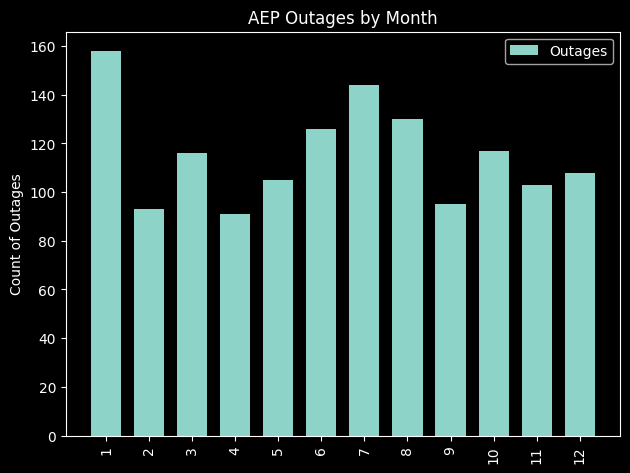

In [20]:
fig, ax = plt.subplots()

x = aep_month_outage_df["Outage Month"]
y = aep_month_outage_df["Event Start Timestamp"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('AEP Outages by Month')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(aep_month_outage_df["Outage Month"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [21]:
aep_week_outage_df = active_aep_df.groupby(['Outage Week'])['Event Start Timestamp'].nunique().to_frame().reset_index()

In [22]:
plant_outages_df = active_aep_df.groupby(['Plant Name'])['Event Start Timestamp'].nunique().to_frame().reset_index().sort_values(by='Event Start Timestamp', ascending=False)

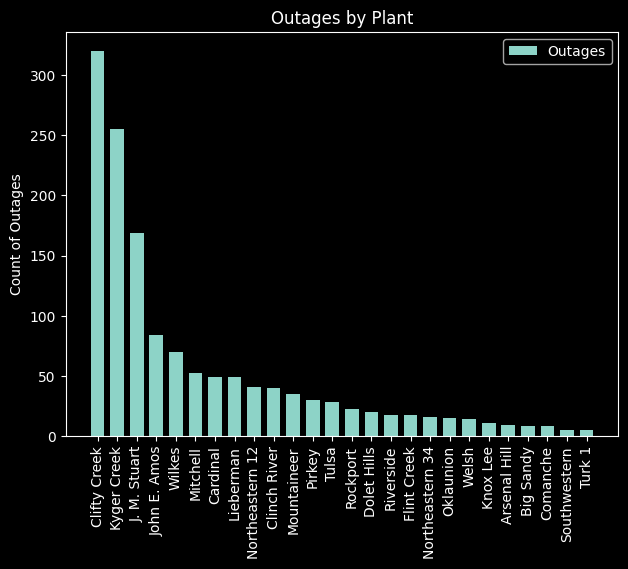

In [23]:
fig, ax = plt.subplots()

x = plant_outages_df["Plant Name"]
y = plant_outages_df["Event Start Timestamp"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('Outages by Plant')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [24]:
outage_duration_df = active_aep_df.groupby(['Plant Name'])['NERC Equivalent Hours'].sum().to_frame().reset_index().sort_values(by='NERC Equivalent Hours', ascending=False)

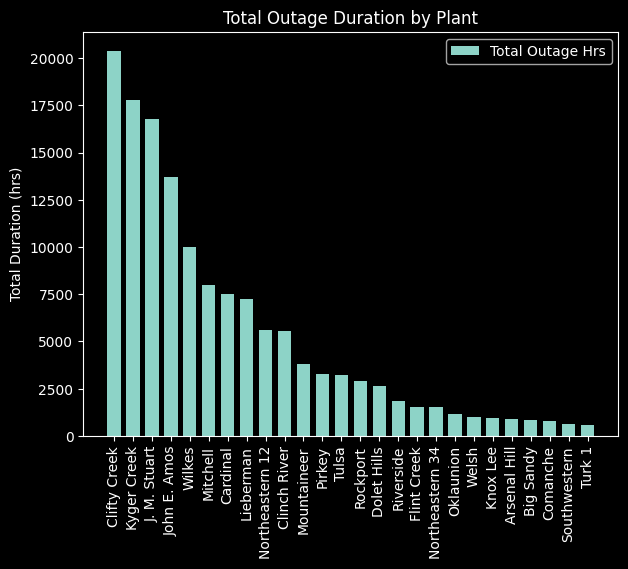

In [25]:
fig, ax = plt.subplots()

x = outage_duration_df["Plant Name"]
y = outage_duration_df["NERC Equivalent Hours"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Total Outage Hrs')
ax.set_title('Total Outage Duration by Plant')
ax.set_ylabel('Total Duration (hrs)')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [26]:
outage_mwh_df = active_aep_df.groupby(['Plant Name'])['NERC MWH Loss'].sum().to_frame().reset_index().sort_values(by='NERC MWH Loss', ascending=False)

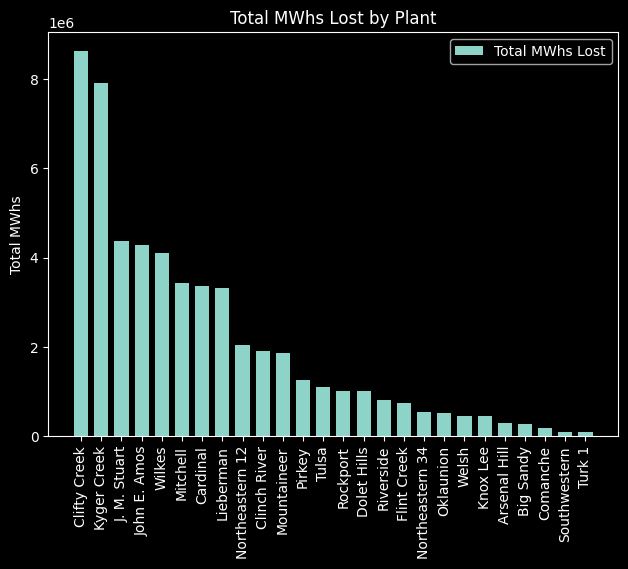

In [27]:
fig, ax = plt.subplots()

x = outage_mwh_df["Plant Name"]
y = outage_mwh_df["NERC MWH Loss"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Total MWhs Lost')
ax.set_title('Total MWhs Lost by Plant')
ax.set_ylabel('Total MWhs')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [28]:
active_aep_df['Unit Name'].nunique()

57

In [29]:
set(active_aep_df['Utility Name'])

{'AEP Generation Resources Inc',
 'AEP West Central Louisianna Electric Co',
 'AEP West Public Service Co of Oklahoma',
 'AEP West Southwestern Electric Power Co',
 'AEP West Texas North Company',
 'Appalachian Power Co. (AEP)',
 'Dayton Power and Light Co.',
 'Indiana Michigan Power Co. (AEP)',
 'Kentucky Power Co. (AEP)',
 'Ohio Valley Elec Corp/Indiana Kentucky Elec Corp (OVEC IKEC)',
 'Ohio Valley Electric Corporation (OVEC)'}

In [30]:
duke_slice_df = active_aep_df[active_aep_df['Utility Name']=='Duke Energy Commercial Asset Management']

In [31]:
duke_slice_df.shape

(0, 18)

In [32]:
set(duke_slice_df['Plant Name'])

set()

NOTES:

Dropping the retired sites from AEP dataset removed these from the data

- Beckjord - https://en.wikipedia.org/wiki/Beckjord_Power_Station
    - previously joint owned, decommisioned in 2014
- Zimmer - https://en.wikipedia.org/wiki/William_H._Zimmer_Power_Station
    - Vistra Corp

### Source 2:
All US Boilers.csv

In [33]:
us_boilers_df = pd.read_csv(r"data/raw_data/All US Boilers.csv")

In [34]:
us_boilers_df.head()

,PARENTNAME,OWNER_NAME,OPER_NAME,PLANT_NAME,PHYS_CITY,P_COUNTY,UNIT_STATE,P_ST_NAME,P_COUNTRY,MARKET_REG,...,TEMP,TEMP_UOM,TEMP_CEL,DESIGNFIRM,CONSTFIRM,MMBTU_HR,KO_YEAR,LATITUDE,LONGITUDE,COGEN_CHP
0,The Blackstone Group Incorporated,Lightstone Generation LLC,Lightstone Generation LLC,James Gavin Power Station,Cheshire,Gallia,OH,Ohio,U.S.A.,Great Lakes,...,1010.0,deg F,543.0,AEP Pro Serv,AEP Pro Serv,NaN,NaN,38.934700,-82.115800,0
1,American Electric Power Company Incorporated,Appalachian Power Company,Appalachian Power Company,John Amos Power Station,Winfield,Putnam,WV,West Virginia,U.S.A.,Mid Atlantic,...,1000.0,deg F,538.0,American Electric Power,American Electric Power,11936.0,NaN,38.473069,-81.822458,0
2,Tennessee Valley Authority,Tennessee Valley Authority,Tennessee Valley Authority,Cumberland Fossil Power Station,Cumberland City,Stewart,TN,Tennessee,U.S.A.,Southeast,...,1003.0,deg F,539.0,Black & Veatch,NaN,NaN,1968.0,36.391944,-87.655555,0
3,Tennessee Valley Authority,Tennessee Valley Authority,Tennessee Valley Authority,Cumberland Fossil Power Station,Cumberland City,Stewart,TN,Tennessee,U.S.A.,Southeast,...,1003.0,deg F,539.0,Black & Veatch,NaN,NaN,1968.0,36.391944,-87.655555,0
4,The Blackstone Group Incorporated,Lightstone Generation LLC,Lightstone Generation LLC,James Gavin Power Station,Cheshire,Gallia,OH,Ohio,U.S.A.,Great Lakes,...,1010.0,deg F,543.0,Black & Veatch,NaN,NaN,NaN,38.934700,-82.115800,0


In [35]:
us_boilers_df.shape

(2538, 48)

In [36]:
us_boilers_df.columns

Index(['PARENTNAME', 'OWNER_NAME', 'OPER_NAME', 'PLANT_NAME', 'PHYS_CITY',
       'P_COUNTY', 'UNIT_STATE', 'P_ST_NAME', 'P_COUNTRY', 'MARKET_REG',
       'WORLD_REG', 'IND_CODE_DESC', 'SIC_CODE', 'PLANT_ID', 'UNIT_NAME',
       'UNIT_ID', 'UNIT_TYPE', 'OUT_DESIGN', 'KO_DATE', 'STARTUP', 'STARTYEAR',
       'SHUTDOWN', 'PRIM_FUEL', 'SECND_FUEL', 'FUEL_GROUP', 'HEAT_RATE',
       'PWR_USAGE', 'U_STATUS', 'BOIL_NAME', 'BOILERTYPE', 'BMFR_NAME',
       'BOIL_INFO', 'STEAM', 'STEAM_UOM', 'STEAM_TON', 'PRESSURE', 'PRES_UOM',
       'PRES_BAR', 'TEMP', 'TEMP_UOM', 'TEMP_CEL', 'DESIGNFIRM', 'CONSTFIRM',
       'MMBTU_HR', 'KO_YEAR', 'LATITUDE', 'LONGITUDE', 'COGEN_CHP'],
      dtype='object')

In [37]:
us_boilers_df['PARENTNAME'].nunique()

320

In [38]:
us_boilers_df['UNIT_ID'].nunique()

2286

In [39]:
us_boilers_df.loc[:, ('SHUTDOWN', 'U_STATUS', 'KO_YEAR')].head()

,SHUTDOWN,U_STATUS,KO_YEAR
0,1-Dec-35,Operational,NaN
1,1-Dec-33,Operational,NaN
2,31-Dec-28,Operational,1968.0
3,31-Dec-26,Operational,1968.0
4,1-Dec-35,Operational,NaN


In [40]:
set(us_boilers_df['U_STATUS'])

{'Closed', 'Mothballed', 'Operational', 'Removed', 'Shuttered'}

In [41]:
us_boilers_byparent = us_boilers_df[us_boilers_df['U_STATUS']=='Operational'].groupby(['PARENTNAME'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False).reset_index()

In [42]:
us_boilers_byparent.head(10)

,PARENTNAME,UNIT_ID
0,American Electric Power Company Incorporated,43
1,Vistra Energy Corporation,41
2,Xcel Energy Incorporated,35
3,Southern Company,29
4,Duke Energy Corporation,29
5,Berkshire Hathaway Incorporated,27
6,Covanta Holding Corporation,26
7,Tennessee Valley Authority,25
8,NRG Energy Incorporated,23
9,Entergy Corporation,21


In [43]:
us_boilers_byparent.UNIT_ID.sum()

1005

In [44]:
us_boilers_df.groupby(['FUEL_GROUP', 'PRIM_FUEL', 'SECND_FUEL'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False)

UNIT_ID
FUEL_GROUP       PRIM_FUEL                        SECND_FUEL                               
Natural Gas      Natural Gas                      Fuel Oil No. 2 Distillate Diesel      209
                                                  Fuel Oil No. 6 Residual               148
Coal             Coal Subbituminous               Natural Gas                           142
                 Coal Bituminous                  Fuel Oil No. 2 Distillate Diesel      131
                                                  Natural Gas                           115
                 Coal Subbituminous               Coal Bituminous                       112
                 Coal Bituminous                  Coal Subbituminous                     61
                 Coal Subbituminous               Fuel Oil No. 2 Distillate Diesel       55
Renewable Energy Waste (solid/sludge)             Natural Gas                            46
Fuel Oil         Fuel Oil No. 6 Residual          Natural Gas                            43
Coal             Coal Bituminous                  Petroleum Coke                         30
Natural Gas      Combined Cycle Waste Heat        Natural Gas                            22
Fuel Oil         Fuel Oil No. 6 Residual          Fuel Oil No. 2 Distillate Diesel       21
Renewable Energy Waste (solid/sludge)             Fuel Oil No. 2 Distillate Diesel       19
Natural Gas      Natural Gas                      Fuel Oil No. 5 Residual                17
Coal             Coal Bituminous                  Fuel Oil No. 6 Residual                14
Natural Gas      Natural Gas                      Fuel Oil                               14
Coal             Coal Lignite                     Coal Subbituminous                     13
                 Coal Bituminous                  Coal Waste                             12
Renewable Energy Wood                             Natural Gas                            12
Natural Gas      Natural Gas                      Coal Subbituminous                     11
Renewable Energy Biomass                          Natural Gas                            10
Coal             Coal Subbituminous               Petroleum Coke                          9
Renewable Energy Wood                             Tire Derived Fuel                       9
Fuel Oil         Fuel Oil No. 2 Distillate Diesel Natural Gas                             9
Coal             Coal Lignite                     Natural Gas                             9
Natural Gas      Natural Gas                      Fuel Oil No. 4 Distillate               7
Coal             Coal Waste                       Fuel Oil No. 2 Distillate Diesel        7
                 Coal Bituminous                  Wood                                    7
Renewable Energy Waste (solid/sludge)             Propane                                 7
Coal             Coal Lignite                     Fuel Oil No. 2 Distillate Diesel        7
Natural Gas      Natural Gas                      Coal Bituminous                         6
Fuel Oil         Fuel Oil No. 6 Residual          Propane                                 6
Coal             Coal Waste                       Coal Bituminous                         6
Fuel Oil         Petroleum Coke                   Fuel Oil No. 2 Distillate Diesel        5
Coal             Coal Bituminous                  Waste (solid/sludge)                    5
Fuel Oil         Petroleum Coke                   Coal Bituminous                         5
Renewable Energy Landfill Gas                     Natural Gas                             4
                 Biomass                          Wood                                    4
Coal             Coal Subbituminous               Coal Waste                              4
                                                  Coal Lignite                            4
Renewable Energy Wood                             Fuel Oil No. 2 Distillate Diesel        4
                                    

In [45]:
us_boilers_df[us_boilers_df['U_STATUS']=='Operational'].groupby(['FUEL_GROUP'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False)

,UNIT_ID
FUEL_GROUP,
Coal,472
Natural Gas,350
Renewable Energy,106
Fuel Oil,77


### Source 3:
Duke Fleet Boiler tube failure data 2005 - 2020.csv

In [46]:
duke_df = pd.read_csv(r"data/raw_data/Duke Fleet Boiler tube failure data 2005 - 2020.csv")

In [47]:
duke_df.head()

,Event ID,Station-Unit,Start Date,Cause Code Name,IsRepeat,TimeBetweenFailure
0,31289,East Bend Steam-2,1/4/05 9:41,Waterwall (Furnace wall) A,False,NaN
1,31290,East Bend Steam-2,1/4/05 10:23,Waterwall (Furnace wall) A,True,0.700000
2,34085,Gibson Steam-3,1/14/05 11:31,Waterwall (Furnace wall) A,False,NaN
3,34086,Gibson Steam-3,1/14/05 14:11,Waterwall (Furnace wall) A,True,2.666667
4,34087,Gibson Steam-3,1/16/05 2:41,Waterwall (Furnace wall) A,True,36.500000


In [48]:
duke_df['Outage Month'] = pd.to_datetime(duke_df['Start Date']).dt.month

In [49]:
duke_df['Outage Week'] = pd.to_datetime(duke_df['Start Date']).dt.isocalendar().week

In [50]:
duke_month_outages_df = duke_df.groupby(['Outage Month'])['Event ID'].nunique().to_frame().reset_index()

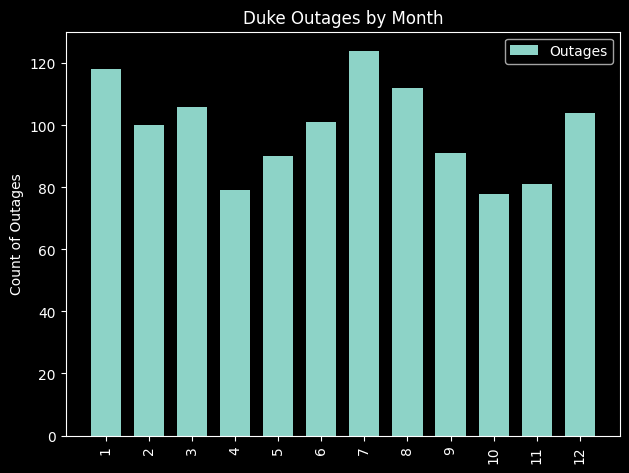

In [51]:
fig, ax = plt.subplots()

x = duke_month_outages_df["Outage Month"]
y = duke_month_outages_df["Event ID"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('Duke Outages by Month')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(duke_month_outages_df["Outage Month"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [52]:
duke_week_outages_df = duke_df.groupby(['Outage Week'])['Event ID'].nunique().to_frame().reset_index()

In [54]:
salesforce_df = pd.read_csv(r"data/raw_data/salesforce.csv")

In [55]:
salesforce_df.head()

,Nominal Thickness (inches),Height/Length,# of Tubes,Tube OD,C2C,Inspection Asset Component Name,Inspection Service,Robot,Inspection: Start Date,Inspection: End Date,Asset: Asset Name,Asset Component Name
0,NaN,41.0,79.0,3.0,4.5,Front Wall,RUG,TOKA 4,7/25/2022,7/27/2022,#1 Power Boiler,Front Wall
1,NaN,78.0,78.0,2.5,3.0,Left Sidewall,RUG,TOKA 4,7/25/2022,7/27/2022,#1 Power Boiler,Left Sidewall
2,NaN,78.0,79.0,3.0,4.5,Rear Wall,RUG,TOKA 4,7/25/2022,7/27/2022,#1 Power Boiler,Rear Wall
3,NaN,78.0,78.0,2.5,3.0,Right Sidewall,RUG,TOKA 4,7/25/2022,7/27/2022,#1 Power Boiler,Right Sidewall
4,0.2,30.0,100.0,2.5,3.0,Waterwall - RUG,RUG,TOKA 4,11/7/2022,11/9/2022,#2 Recovery Boiler,Waterwall


In [56]:
salesforce_df.columns

Index(['Nominal Thickness (inches)', 'Height/Length', '# of Tubes', 'Tube OD',
       'C2C', 'Inspection Asset Component Name', 'Inspection Service', 'Robot',
       'Inspection: Start Date', 'Inspection: End Date', 'Asset: Asset Name',
       'Asset Component Name'],
      dtype='object')

In [57]:
salesforce_df['Nominal Thickness (inches)'].describe()

count    668.000000
mean       0.259373
std        0.364204
min       -0.001000
25%        0.203000
50%        0.240000
75%        0.250000
max        4.500000
Name: Nominal Thickness (inches), dtype: float64

In [58]:
salesforce_df['Nominal Thickness (inches)'].median()

0.24

In [59]:
salesforce_df['# of Tubes'].describe()

count    643.000000
mean      94.519440
std      124.327189
min        1.000000
25%       20.000000
50%       52.000000
75%      103.000000
max      880.000000
Name: # of Tubes, dtype: float64

In [60]:
salesforce_df[salesforce_df['Nominal Thickness (inches)'] > 0.25]['Asset: Asset Name'].nunique()

22

In [61]:
salesforce_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Nominal Thickness (inches)       668 non-null    float64
 1   Height/Length                    644 non-null    float64
 2   # of Tubes                       643 non-null    float64
 3   Tube OD                          716 non-null    float64
 4   C2C                              717 non-null    float64
 5   Inspection Asset Component Name  728 non-null    object 
 6   Inspection Service               727 non-null    object 
 7   Robot                            624 non-null    object 
 8   Inspection: Start Date           644 non-null    object 
 9   Inspection: End Date             644 non-null    object 
 10  Asset: Asset Name                728 non-null    object 
 11  Asset Component Name             728 non-null    object 
dtypes: float64(5), object(

In [62]:
set(salesforce_df['Asset: Asset Name'])

{'#1 Power Boiler',
 '#2 Recovery Boiler',
 '23-H-3-CO Boiler 4 Water wall and Bullnose',
 'AES Petersburg - Unit 3 Boiler',
 'AES Petersburg - Unit 4 Boiler',
 'Angamos Boiler',
 'B&W waste boiler',
 'BFB Boiler',
 'BFB Boiler (128MW)',
 'BPCP Boiler',
 'Bark Boiler',
 'Boiler',
 'Boiler #1',
 'Boiler 10',
 'Boiler 6',
 'Boiler 7',
 'Boiler B',
 'Boiler C',
 'Boiler Slopes',
 'Boiler Unit #4',
 'Boiler Unit 1',
 'Boiler Unit 2',
 'Boiler Unit 3',
 'Boiler Unit 5',
 'CFB (Cilegon ST 02)  150MW',
 'CFB Boiler',
 'CFB Boiler #1',
 'CFB Boiler #2',
 'CFB Boiler NO2',
 'CFB Unit #1',
 'CFB boiler - (150MW Thermal/50MW Electric))',
 'CFB by SFW (150Mw heating / ~50MW electrical))',
 'CFBC biomass boiler',
 'Cilegon ST 01 - CFB boiler',
 'Coal Boiler',
 'Covanta Montgomery - Unit #1 Boiler',
 'Covanta Montgomery - Unit #3 Boiler',
 'Cross - Unit 4',
 'Cross Unit 4 Waterwalls',
 'Economizer tube bank',
 'FD4',
 'Furnace 5',
 'Gas Boiler',
 'Ingredion Argo - Boiler #10',
 'K11 PC Boiler',
 'Le

### Source 5:
portalservice_power_units.json

In [63]:
with open(r'data/raw_data/portalservice_power_inspections_2022.json') as json_data:
    d = json.loads(json_data.read())
    json_data.close()

In [64]:
portalservice_power_inspections_2022_df = pd.json_normalize(d)

In [65]:
portalservice_power_inspections_2022_df.head()

,Inspection.id,Inspection.zero_offset,Inspection.show_excel,Inspection.target_release_time,Inspection.inspection_type,Inspection.sort_order,Inspection.ndt_method_type,Inspection.data_import,Inspection.name,Inspection.sales_robotic_service_id,...,Location.customer_id,Location.city,Location.slug,Location.slack_channel,Customer.id,Customer.logo,Customer.salesforce_id,Customer.drive_folder_id,Customer.name,Customer.slug
0,4060,None,1,None,wall_thickness,3241,ut,0,None,NaN,...,38,West Lafayette,wade-utility-plant-c9e652,insp_purdue_wade,38,customer_logos/purdue.png,0011U00000EHUhKQAX,0B61E5R0McQ-1Zmt2cDVBaHZaTVE,Purdue University,purdue-university-7a0ab8
1,4061,None,1,None,coating_thickness,3242,mi,0,None,NaN,...,38,West Lafayette,wade-utility-plant-c9e652,insp_purdue_wade,38,customer_logos/purdue.png,0011U00000EHUhKQAX,0B61E5R0McQ-1Zmt2cDVBaHZaTVE,Purdue University,purdue-university-7a0ab8
2,4067,None,1,None,wall_thickness,3228,ut,0,None,NaN,...,206,Aquasco,genon-chalk-point-generating-station-11b972,insp_genon_chalk_chalk-point,206,customer_logos/genon.png,0011U00000etljVQAQ,1MjMh0XmtC8D7u-_bZPgSfZUUCeYcHxjc,GenOn,genon-corporate-a407ff
3,4068,None,1,None,wall_thickness,3229,ut,0,None,NaN,...,206,Aquasco,genon-chalk-point-generating-station-11b972,insp_genon_chalk_chalk-point,206,customer_logos/genon.png,0011U00000etljVQAQ,1MjMh0XmtC8D7u-_bZPgSfZUUCeYcHxjc,GenOn,genon-corporate-a407ff
4,4069,None,1,None,wall_thickness,3230,ut,0,None,NaN,...,206,Aquasco,genon-chalk-point-generating-station-11b972,insp_genon_chalk_chalk-point,206,customer_logos/genon.png,0011U00000etljVQAQ,1MjMh0XmtC8D7u-_bZPgSfZUUCeYcHxjc,GenOn,genon-corporate-a407ff


In [66]:
portalservice_power_inspections_2022_df.columns

Index(['Inspection.id', 'Inspection.zero_offset', 'Inspection.show_excel',
       'Inspection.target_release_time', 'Inspection.inspection_type',
       'Inspection.sort_order', 'Inspection.ndt_method_type',
       'Inspection.data_import', 'Inspection.name',
       'Inspection.sales_robotic_service_id', 'Inspection.date',
       'Inspection.component_id', 'Inspection.notes', 'Inspection.external_id',
       'Inspection.slug', 'Inspection.demo', 'Inspection.read_only',
       'Inspection.status', 'Inspection.job_id', 'Component.id',
       'Component.tube_diameter', 'Component.tube_spacing',
       'Component.sea_level', 'Component.shell_diameter',
       'Component.slope_angle', 'Component.lat', 'Component.lng',
       'Component.material_type', 'Component.wall_nominal_thickness',
       'Component.wall_warning_thickness',
       'Component.coating_nominal_thickness',
       'Component.coating_warning_thickness', 'Component.component_type',
       'Component.sales_asset_type_id', 'Com

In [163]:
ref_df = portalservice_power_inspections_2022_df.loc[:,(
    'Inspection.slug',
    'Component.material_type',
    'Unit.fuel_type',
    'Unit.capacity',
    'Unit.total_tubes',
    'Customer.name'
)]

In [164]:
ref_df.head()

,Inspection.slug,Component.material_type,Unit.fuel_type,Unit.capacity,Unit.total_tubes,Customer.name
0,20221208-a5eb08,carbon_steel,,0,0,Purdue University
1,20221208-659a62,carbon_steel,,0,0,Purdue University
2,20221205-092b04,carbon_steel,None,0,0,GenOn
3,20221206-ab7b6a,carbon_steel,None,0,0,GenOn
4,20221206-bbeae0,carbon_steel,None,0,0,GenOn


In [102]:
trim_inspslug_nom_df = portalservice_power_inspections_2022_df.loc[:, ('Inspection.slug', 'Component.wall_nominal_thickness')]
trim_inspslug_nom_df.rename(columns={'Inspection.slug': 'slug',	'Component.wall_nominal_thickness': 'nominal'}, inplace=True)
median_nominal = trim_inspslug_nom_df['nominal'].median()
print('Nominal used to fillna:  {}'.format(median_nominal))
trim_inspslug_nom_df['nominal'].fillna(median_nominal, inplace=True)

Nominal used to fillna:  0.25


In [147]:
trim_inspslug_nom_df.shape

(266, 2)

In [148]:
trim_inspslug_nom_df.head()

,slug,nominal
0,20221208-a5eb08,0.180
1,20221208-659a62,0.180
2,20221205-092b04,0.375
3,20221206-ab7b6a,0.375
4,20221206-bbeae0,0.375


In [67]:
distinct_2022_power_inspection_slugs = list(set(portalservice_power_inspections_2022_df['Inspection.slug']))

In [68]:
len(distinct_2022_power_inspection_slugs)

266

In [78]:
distinct_2022_power_inspection_slugs[0]

'20220613-fee995'

In [81]:
inspection_slug = distinct_2022_power_inspection_slugs[1]

### Get actual inspection data

In [118]:
prod = {
    "url_start": "https://portal-service.cloud.geckorobotics.com/api/v1/deliverables/",
    "url_end": "/binned_plot_data.json", 
    "token": "eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6IkVpeTN0a0l0bzZ0SDFTZ1VZdUdXVCJ9.eyJpc3MiOiJodHRwczovL2dlY2tvcm9ib3RpY3MudXMuYXV0aDAuY29tLyIsInN1YiI6Imdvb2dsZS1vYXV0aDJ8MTAxODIxNjU3MzQ0ODI0ODQxMjA5IiwiYXVkIjpbImNsb3VkLmdlY2tvcm9ib3RpY3MuY29tIiwiaHR0cHM6Ly9nZWNrb3JvYm90aWNzLnVzLmF1dGgwLmNvbS91c2VyaW5mbyJdLCJpYXQiOjE2NzMyMTcyMDAsImV4cCI6MTY3MzMwMzYwMCwiYXpwIjoiSm1la3lLS0RsM2liRzdQbExRY2JLWHZoekx1UTRaQ08iLCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGVtYWlsIiwicGVybWlzc2lvbnMiOlsiY29sbGVjdGlvbnM6M2RfbW9kZWxzOmVkaXQiLCJjb2xsZWN0aW9uczphZG5vYy1hYnUtZGhhYmktbmF0aW9uYWwtb2lsLWNvbXBhbnktMmE1MzY0OmVkaXQiLCJjb2xsZWN0aW9uczphZXAtYTgyZjE4OmVkaXQiLCJjb2xsZWN0aW9uczphZXMtZWE0ZjMwOmVkaXQiLCJjb2xsZWN0aW9uczpiYXNmLTBmMmNiZTplZGl0IiwiY29sbGVjdGlvbnM6Y2hldnJvbi0wMWE1M2Y6ZWRpdCIsImNvbGxlY3Rpb25zOmNvbWJpbmVkX2NvbXBvbmVudF9kZnM6ZWRpdCIsImNvbGxlY3Rpb25zOmRvbXRhci03NDVhNWE6ZWRpdCIsImNvbGxlY3Rpb25zOmR1a2UtN2YyZmFmOmVkaXQiLCJjb2xsZWN0aW9uczplYmVuc2J1cmctcG93ZXItY29tcGFueS0wZTEyMWY6ZWRpdCIsImNvbGxlY3Rpb25zOmV4eG9uLTdmZDJhYjplZGl0IiwiY29sbGVjdGlvbnM6ZmRlLWRlbW86ZWRpdCIsImNvbGxlY3Rpb25zOmdlb3JnaWEtcGFjaWZpYy1hMWVjNTM6ZWRpdCIsImNvbGxlY3Rpb25zOm1hbnVhbF9pbnNwZWN0aW9uczplZGl0IiwiY29sbGVjdGlvbnM6bm9uc3BlY2lmaWMtY3VzdG9tZXI6ZWRpdCIsImNvbGxlY3Rpb25zOnJvbGxvdXRfaW1hZ2VzOmVkaXQiLCJjb2xsZWN0aW9uczp1cy1uYXZ5LTY5YTcyYTplZGl0IiwiZ2Vja286cmVhZCIsImdlY2tvOnJvbG9kZXg6ZWRpdCJdfQ.dRFHyVFLSzbAATFi4AX3trlIm7lmLUPiHOpLBOLsOwpfLsHwBzBSoJqcnFuof6ESEiHLwa36MwYFwh7eyfx8OBWVfOAFY_L6HkAckdOYlJD6cmoCUXDJnKVFKSB62g9aFHcUyaQ2PUWsX8Jn1UH0-AeddaHrMLZg2CbP7J272fX_RJsRxUzEPrWWVZzej9PCH7jZkSYu6dOYCiEh3l-a2XmAVe4H8mGpY2dt6gQEbWld1rqiZxZnt9xv_p4guN8RREmpFX6qwBolcpBO9mndwD9iXKz-sd1QnSzh6WeZrDCRdVMG7fQFWwXNDSG1s_XE4hP6YtntwJGieXfBwsL2qw"
}

headers = {"accept": "application/json", "Authorization": f"Bearer {prod['token']}"}

print(f"Making Req...")
req = requests.get(f"{prod['url_start']}{inspection_slug}{prod['url_end']}", headers=headers)
#print(f"\tRequest Text: {req.text}")
print(f"...Req Done")

Making Req...
...Req Done


In [84]:
inspection_df = pd.DataFrame(req.json()['plots'][0]['data'])

In [85]:
inspection_df.head()

,plot_x,customer_y,x_bin,y_bin,customer_x,plot_y,thickness
0,807.0,-9.25,807.0,-9.25,63,-9.25,0.24940
1,809.0,-9.25,809.0,-9.25,65,-9.25,0.24592
2,811.0,-9.25,811.0,-9.25,67,-9.25,0.26448
3,813.0,-9.25,813.0,-9.25,69,-9.25,0.26216
4,817.0,-9.25,817.0,-9.25,73,-9.25,0.24592


OK so now we have an inspection df, lets group by tube # and get a min thickness for each tube, if min is less than .4*nominal then counter + 1 ... arrive at a number of at risk tubes per inspection ... turn that into a % of tubes at risk based on total tubes ?

In [129]:
def analyze_inspection_df(inspection_df, nominal, threshold):
    """
    Take inspection df return key stats
    input:
    inspection_df
    nominal - designed thickness, t at time 0
    threshold - target threshold for count (ie 40% of nominal => .4)
    output:
    min_t
    max_t
    ??? list of min_t's grouped by tube #
    count of tubes where min_t is < nominal
    """

    min_t = inspection_df.thickness.min()
    max_t = inspection_df.thickness.max()
    
    target = nominal*threshold

    min_t_by_tube_list = inspection_df.groupby(['customer_x'])['thickness'].min().to_list()
    
    ## NOTE: chnaged this to just be any, not grouped by tube above
    #critical_tubes_count = len([t for t in min_t_by_tube_list if t < target])
    critical_tubes_count = len([t for t in inspection_df.thickness if t < target])
    
    return min_t, max_t, critical_tubes_count

In [120]:
min_thicknesses = inspection_df.groupby(['customer_x'])['thickness'].min().to_list()

In [123]:
max(min_thicknesses)

0.3851200044155121

In [122]:
min(min_thicknesses)

0.30856001377105713

In [124]:
[t for t in min_thicknesses if t < 0.31]

[0.30856001377105713]

In [105]:
threshold = .4

In [139]:
targets_df = trim_inspslug_nom_df.head()

In [140]:
targets_df

,slug,nominal
0,20221208-a5eb08,0.180
1,20221208-659a62,0.180
2,20221205-092b04,0.375
3,20221206-ab7b6a,0.375
4,20221206-bbeae0,0.375


In [141]:
targets_df.shape

(5, 2)

In [154]:
def check_thickness(targets_df, threshold):
    """
    Takes a dataframe of target inspection slugs and nominals and returns analysis data
    inputs: targets_df, threshold
    outputs: analysis row, min,max,count critical
    """
    data_list = []

    for row in range(len(targets_df)):
        inspection_slug = targets_df.loc[row, 'slug']
        nominal = targets_df.loc[row, 'nominal']
        
        if row%10 == 0:
            print(row)

        req = requests.get(f"{prod['url_start']}{inspection_slug}{prod['url_end']}", headers=headers)
        if req.json():
            try:
                inspection_df = pd.DataFrame(req.json()['plots'][0]['data'])

                min_t, max_t, critical_tubes_count = analyze_inspection_df(inspection_df, nominal, threshold)

                data = [inspection_slug, nominal, min_t, max_t, critical_tubes_count]
                #print(data)
                data_list.append(data)
            except:
                print('error')
            
        else:
            print('Inspection slug failed to return data: {}'.format(inspection_slug))

            
    data_df = pd.DataFrame(data_list, columns=['slug', 'nominal', 'min_t', 'max_t', 'critical_readings'])
    
    return data_df

In [146]:



check_thickness(targets_df, threshold)

['20221208-a5eb08', 0.18, 0.05916000157594681, 0.22387999296188354, 1]
['20221208-659a62', 0.18, 0.09999999403953552, 51.89999771118164, 0]
['20221205-092b04', 0.375, 0.25172001123428345, 0.450080007314682, 0]
['20221206-ab7b6a', 0.375, 0.3433600068092346, 0.4628399908542633, 0]
['20221206-bbeae0', 0.375, 0.30856001377105713, 0.4477599859237671, 0]


,slug,nominal,min_t,max_t,critical_readings
0,20221208-a5eb08,0.180,0.05916,0.223880,1
1,20221208-659a62,0.180,0.10000,51.899998,0
2,20221205-092b04,0.375,0.25172,0.450080,0
3,20221206-ab7b6a,0.375,0.34336,0.462840,0
4,20221206-bbeae0,0.375,0.30856,0.447760,0


In [155]:
critical_df = check_thickness(trim_inspslug_nom_df, threshold)

0
10
20
30
40
50
error
error
60
error
error
error
error
70
error
error
error
error
error
error
error
error
80
error
error
error
error
error
error
error
error
error
error
90
error
error
error
error
error
100
error
error
110
120
error
error
error
error
130
error
error
error
error
error
error
error
140
150
160
error
170
error
error
error
error
error
180
error
error
190
error
error
error
200
error
error
210
error
error
220
230
error
error
error
error
240
error
error
error
error
250
260
error


In [156]:
critical_df.shape

(200, 5)

In [157]:
critical_df.head()

,slug,nominal,min_t,max_t,critical_readings
0,20221208-a5eb08,0.180,0.05916,0.223880,1
1,20221208-659a62,0.180,0.10000,51.899998,0
2,20221205-092b04,0.375,0.25172,0.450080,0
3,20221206-ab7b6a,0.375,0.34336,0.462840,0
4,20221206-bbeae0,0.375,0.30856,0.447760,0


In [158]:
critical_df.critical_readings.sum()

8778

In [160]:
critical_df[critical_df['critical_readings'] != 0].shape

(42, 5)

In [165]:
critical_df.sort_values(by='critical_readings', ascending=False).head(20)

,slug,nominal,min_t,max_t,critical_readings
195,20220114-540a39,0.250,0.05916,0.234320,1509
42,20221011-7c7e5f,0.300,0.05916,0.397880,1381
169,20220321-ad5368,0.250,0.05916,1.642560,1033
90,20220523-332ac6,0.385,0.07772,0.437320,913
87,20220620-e6ea8d,0.250,0.06032,0.263320,535
91,20220523-64417d,0.385,0.09396,0.366560,509
41,20221011-18c8e9,0.280,0.05916,0.407160,449
153,20220414-938683,0.250,0.05916,0.386280,401
92,20220517-dd156d,0.325,0.05916,0.408320,376
181,20220308-369097,0.303,0.09512,0.314360,329


In [167]:
critical_df.head(1)

,slug,nominal,min_t,max_t,critical_readings
0,20221208-a5eb08,0.18,0.05916,0.22388,1


In [168]:
ref_df.head(1)

,Inspection.slug,Component.material_type,Unit.fuel_type,Unit.capacity,Unit.total_tubes,Customer.name
0,20221208-a5eb08,carbon_steel,,0,0,Purdue University


In [169]:
comb_df = critical_df.merge(ref_df, how='left', left_on='slug', right_on='Inspection.slug')

In [171]:
comb_df.head()

,slug,nominal,min_t,max_t,critical_readings,Inspection.slug,Component.material_type,Unit.fuel_type,Unit.capacity,Unit.total_tubes,Customer.name
0,20221208-a5eb08,0.180,0.05916,0.223880,1,20221208-a5eb08,carbon_steel,,0,0,Purdue University
1,20221208-659a62,0.180,0.10000,51.899998,0,20221208-659a62,carbon_steel,,0,0,Purdue University
2,20221205-092b04,0.375,0.25172,0.450080,0,20221205-092b04,carbon_steel,None,0,0,GenOn
3,20221206-ab7b6a,0.375,0.34336,0.462840,0,20221206-ab7b6a,carbon_steel,None,0,0,GenOn
4,20221206-bbeae0,0.375,0.30856,0.447760,0,20221206-bbeae0,carbon_steel,None,0,0,GenOn


In [177]:
comb_df.iloc[0,0][4:6]

'12'

In [175]:
set(comb_df['Customer.name'])

{'AEP',
 'AES',
 'ALCOA',
 'Archer Daniels Midland (ADM)',
 'Cardinal',
 'City of Springfield Utilities (Corporate)',
 'Consolidated Edison Company of New York (Corporate)',
 'Consumers Energy (Corporate)',
 'Covanta',
 'Dominion',
 'Duke Energy',
 'East Kentucky Power Coop (EKPC)',
 'Ebensburg Power Company',
 'GenOn',
 'Great River Energy',
 'Hallador Power Company',
 'Ingredion, Inc.',
 'JEA',
 'Kentucky Utilities',
 'Koch Industries (Corporate)',
 'LG&E',
 'Lower Colorado River Authority',
 'MidAmerican Energy',
 'NRG',
 'National Grid',
 'Pacificorp',
 'Purdue University',
 'Southern Co',
 'Southern Illinois Power Cooperative',
 'Stonghold Digital Mining',
 'Sunflower Electric Power Corp',
 'Talen Energy',
 'Tucson Electric Power',
 'University of North Carolina (UNC)',
 'Vistra Luminant Energy',
 'Xcel Energy'}

In [180]:
comb_df.groupby(['Customer.name'])['critical_readings'].sum().to_frame().sort_values(by='critical_readings', ascending=False)

,critical_readings
Customer.name,
Hallador Power Company,3252
Covanta,2591
MidAmerican Energy,1152
Tucson Electric Power,784
Pacificorp,466
NRG,191
Great River Energy,170
Southern Co,67
AES,50


### Let's build a new dataframe, inspection slugs and key metrics

In [71]:
with open(r'data/raw_data/portalservice_power_units.json') as json_data:
    d = json.loads(json_data.read())
    json_data.close()

In [72]:
portalservice_power_units_df = pd.json_normalize(d)

In [73]:
portalservice_power_units_df.head()

,Unit.id,Unit.description,Unit.built_date,Unit.fuel_type,Unit.inspection_code,Unit.retirement_date,Unit.sales_asset_category_id,Unit.salesforce_id,Unit.name,Unit.location_id,...,Location.customer_id,Location.city,Location.slug,Location.slack_channel,Customer.id,Customer.logo,Customer.salesforce_id,Customer.drive_folder_id,Customer.name,Customer.slug
0,1,,None,,,None,1.0,02i1U0000028OlBQAU,Boiler 7,1,...,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
1,5,,None,None,None,None,1.0,02i1U0000028Ol6QAE,Boiler 6 - 2016,1,...,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
2,1738,,None,None,None,None,1.0,None,Boiler 6,1,...,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
3,1796,,None,None,None,None,NaN,None,Boiler 7 - 2016,1,...,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
4,2,,None,,,None,NaN,,Boiler 1,2,...,2,Westlake,westlake-438042,,2,customer_logos/nisco.png,0011U00001JVH1QQAX,1tt5XBaYFsL15dNBkQJAsZeYRdilVGAAs,NISCO,nisco-7b0507


In [74]:
portalservice_power_units_df.shape

(780, 38)

In [75]:
portalservice_power_units_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unit.id                         780 non-null    int64  
 1   Unit.description                719 non-null    object 
 2   Unit.built_date                 23 non-null     object 
 3   Unit.fuel_type                  606 non-null    object 
 4   Unit.inspection_code            602 non-null    object 
 5   Unit.retirement_date            4 non-null      object 
 6   Unit.sales_asset_category_id    239 non-null    float64
 7   Unit.salesforce_id              623 non-null    object 
 8   Unit.name                       780 non-null    object 
 9   Unit.location_id                780 non-null    int64  
 10  Unit.slug                       780 non-null    object 
 11  Unit.capacity                   780 non-null    float64
 12  Unit.inspection_interval_years  780 

### Ideas to filter for just boilers:

- boiler in name or slug
- unit name or slug
- drop anything with silo or bunker in the name or slug
- contains econo or eva
- drop anything with tank

In [76]:
portalservice_power_units_df.loc[:, ('Unit.name', 'Unit.slug')].head(10)

,Unit.name,Unit.slug
0,Boiler 7,boiler-7-224f9b
1,Boiler 6 - 2016,boiler-6-0f5b4b
2,Boiler 6,boiler-6-21a474
3,Boiler 7 - 2016,boiler-7-2016-5a769f
4,Boiler 1,boiler-1-4fb4ce
5,Boiler 1,boiler-1-e96665
6,Boiler 10,boiler-10-7055ca
7,49I03 IXB Cation,anion-tanks-5be568
8,49I04 IWB Anion,anion-tank-2-b308e8
9,49I05 IXC Cation,anion-tank-3-916d1b


In [77]:
portalservice_power_units_df.describe()

,Unit.id,Unit.sales_asset_category_id,Unit.location_id,Unit.capacity,Unit.inspection_interval_years,Unit.latitude,Unit.longitude,Unit.total_tubes,Location.id,Location.lat,Location.lng,Location.customer_id,Customer.id
count,780.000000,239.000000,780.000000,780.000000,780.000000,780.000000,7.800000e+02,780.000000,780.000000,774.000000,774.000000,780.00000,780.00000
mean,998.507692,5.891213,239.164103,3.284487,0.148397,0.687801,-1.024765e+13,3.693590,239.164103,35.429891,-83.376395,106.49359,106.49359
std,647.343142,3.275303,225.016237,29.721559,0.909327,5.930977,2.862012e+14,73.043042,225.016237,13.961600,36.568314,107.72840,107.72840
min,1.000000,1.000000,1.000000,0.000000,0.000000,-23.830503,-7.993163e+15,0.000000,1.000000,-33.437220,-158.129097,1.00000,1.00000
25%,427.500000,4.000000,55.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,55.000000,33.665995,-97.399950,20.00000,20.00000
50%,969.500000,5.000000,149.500000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,149.500000,38.523460,-87.306205,86.50000,86.50000
75%,1554.750000,9.000000,369.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,369.000000,40.768470,-80.065280,152.00000,152.00000
max,2152.000000,15.000000,886.000000,500.000000,10.000000,61.107582,1.511512e+02,1918.000000,886.000000,61.107500,151.244200,480.00000,480.00000
